# Human Activity Recognition – Datenanalyse & Modellierung

Dieses Notebook dokumentiert die vollständige Datenanalyse und Vorbereitung für das Projekt **"Human Activity Recognition" (HAR)**. Ziel ist es, mithilfe eines LSTM-Modells menschliche Aktivitäten basierend auf Sensordaten zu klassifizieren. Alle Schritte folgen dem CRISP-DM-Modell und sind methodisch nachvollziehbar dokumentiert.

## Inhalt
Folgende Schritte werden in diesem Notebook umgesetzt:

1. **Datenverständnis (Data Understanding)**
   - Überblick über die Datenstruktur
   - Zielverteilung und Merkmalsanalyse
   - Visualisierung numerischer Merkmale & Korrelationen

2. **Datenvorbereitung (Data Preparation)**
   - Label-Encoding der Zielvariable
   - Standardisierung der Eingabedaten
   - Umwandlung in Tensorformate für PyTorch
   - Aufbereitung für sequenzbasierte Modelle (LSTM)

3. **Modellierung (Modeling)**
   - Training eines LSTM-Klassifikators mit PyTorch
   - Hyperparameteroptimierung mittels Optuna
   - MLflow-Tracking aller Experimente und Metriken

4. **Evaluierung (Evaluation)**
   - Vergleich mit Dummy Classifier
   - Confusion Matrix & Klassifikationsbericht
   - Permutation Feature Importance zur Merkmalsrelevanz

---

**Zum vollständigen Projekt inkl. Quellcode, Skripten und Modellen**:  
[GitHub Repository – `mlp-har-activity`](https://github.com/Mehmet1700/mlp-har-activity)

---

In [ ]:
# Biblotheken importieren
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
import plotly.express as px
from datetime import datetime
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature
mlflow.set_tracking_uri("file:../logs/mlruns")
mlflow.set_experiment("LSTM_HAR_Optuna")



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# Rohdaten laden (Train & Test Set)
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

# Einen Blick auf die ersten Zeilen werfen
display(train_df.head())
display(test_df.head())

# Größe der Datensätze anzeigen
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Statistische Übersicht
print("Train description:\n", train_df.describe())
print("Test description:\n", test_df.describe())


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,STANDING


Train shape: (7352, 563)
Test shape: (2947, 563)
Train description:
        tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        7352.000000        7352.000000        7352.000000   
mean            0.274488          -0.017695          -0.109141   
std             0.070261           0.040811           0.056635   
min            -1.000000          -1.000000          -1.000000   
25%             0.262975          -0.024863          -0.120993   
50%             0.277193          -0.017219          -0.108676   
75%             0.288461          -0.010783          -0.097794   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       7352.000000       7352.000000       7352.000000       7352.000000   
mean          -0.605438         -0.510938         -0.604754         -0.630512   
std            0.448734          0.502645          0.418687          0.424073   
min         

In [6]:
# Boxplots der ersten 10 numerischen Features
data_dictionary = pd.DataFrame({
    'Spalte': train_df.columns[:10],
    'Beschreibung': [
        'Mean of Body Acceleration X',
        'Mean of Body Acceleration Y',
        'Mean of Body Acceleration Z',
        'Standard deviation of Body Acceleration X',
        'Standard deviation of Body Acceleration Y',
        'Standard deviation of Body Acceleration Z',
        'Median absolute deviation X',
        'Median absolute deviation Y',
        'Median absolute deviation Z',
        'Maximum value of Body Acceleration X',
    ],
    'Typ': [str(train_df[col].dtype) for col in train_df.columns[:10]]
})
display(data_dictionary)


,Spalte,Beschreibung,Typ
0,tBodyAcc-mean()-X,Mean of Body Acceleration X,float64
1,tBodyAcc-mean()-Y,Mean of Body Acceleration Y,float64
2,tBodyAcc-mean()-Z,Mean of Body Acceleration Z,float64
3,tBodyAcc-std()-X,Standard deviation of Body Acceleration X,float64
4,tBodyAcc-std()-Y,Standard deviation of Body Acceleration Y,float64
5,tBodyAcc-std()-Z,Standard deviation of Body Acceleration Z,float64
6,tBodyAcc-mad()-X,Median absolute deviation X,float64
7,tBodyAcc-mad()-Y,Median absolute deviation Y,float64
8,tBodyAcc-mad()-Z,Median absolute deviation Z,float64
9,tBodyAcc-max()-X,Maximum value of Body Acceleration X,float64


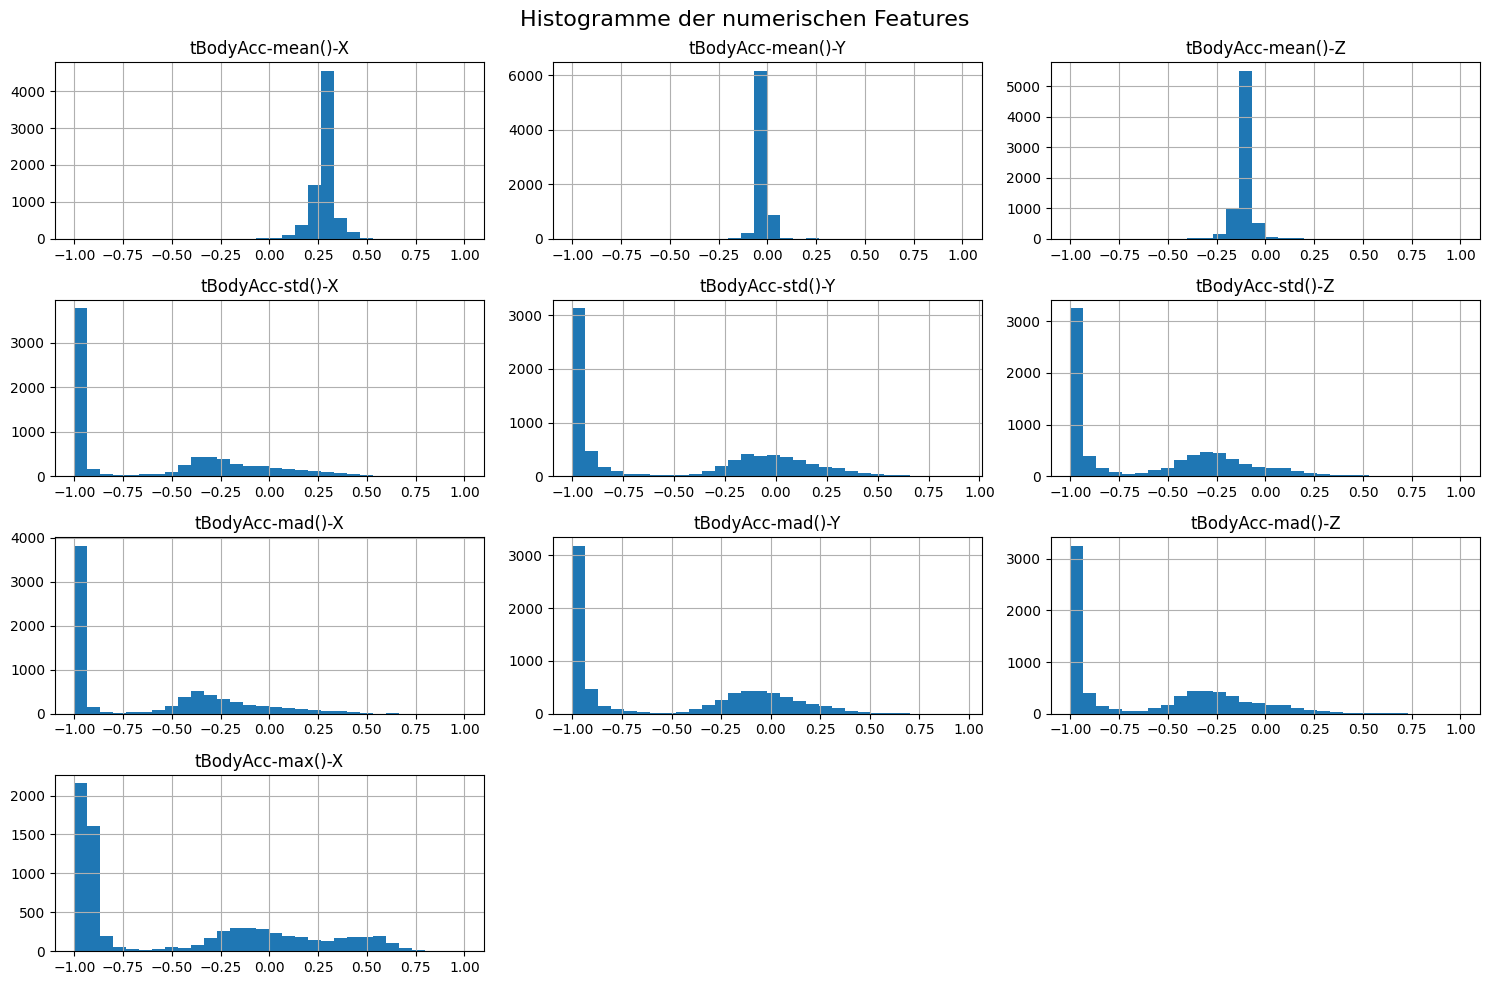

In [7]:
# Numerische Verteilungen (Histogramme)
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
train_df[numeric_cols[:10]].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogramme der numerischen Features", fontsize=16)
plt.tight_layout()
plt.show()

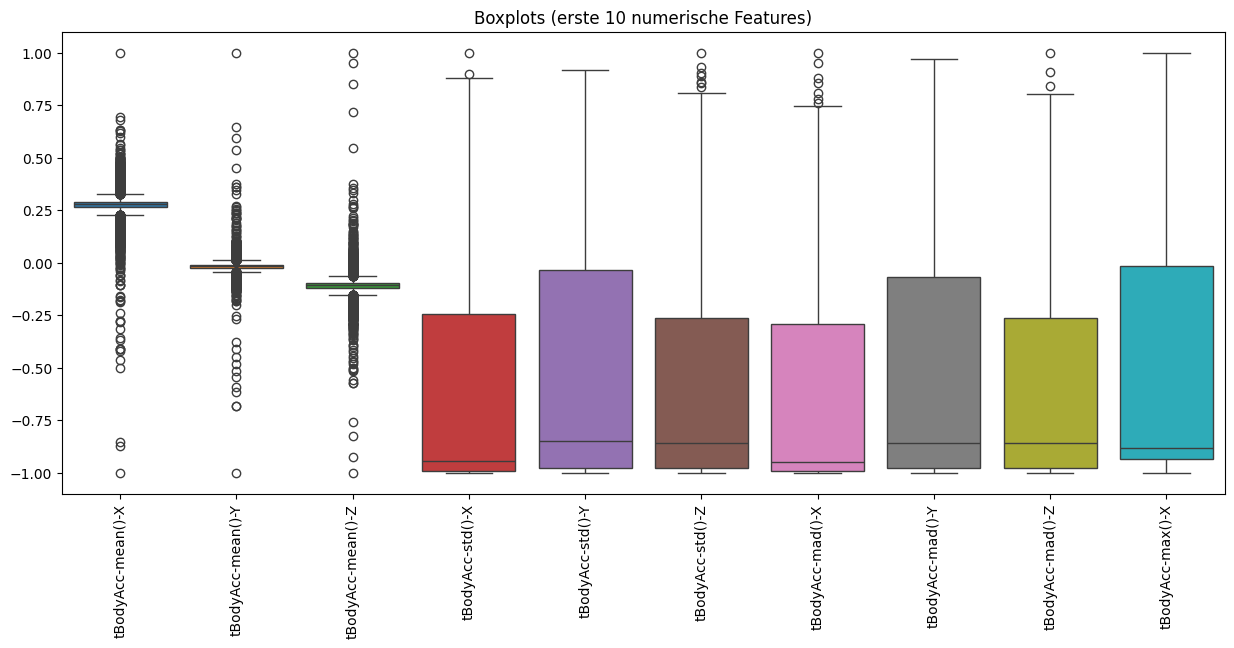

Anzahl potenzieller Ausreißer pro Feature:
 tBodyAcc-mean()-X                   94
tBodyAcc-mean()-Y                   64
tBodyAcc-mean()-Z                  109
tBodyAcc-std()-X                    10
tBodyAcc-std()-Z                    31
                                  ... 
fBodyBodyGyroJerkMag-meanFreq()     36
fBodyBodyGyroJerkMag-skewness()     53
fBodyBodyGyroJerkMag-kurtosis()    139
angle(Y,gravityMean)                87
angle(Z,gravityMean)                73
Length: 509, dtype: int64


In [8]:
# Boxplots für Ausreißer
plt.figure(figsize=(15, 6))
sns.boxplot(data=train_df[numeric_cols[:10]])
plt.xticks(rotation=90)
plt.title("Boxplots (erste 10 numerische Features)")
plt.show()

from scipy import stats
z_scores = np.abs(stats.zscore(train_df.select_dtypes(include='float64')))
outlier_count = (z_scores > 3).sum(axis=0)
print("Anzahl potenzieller Ausreißer pro Feature:\n", outlier_count[outlier_count > 0])

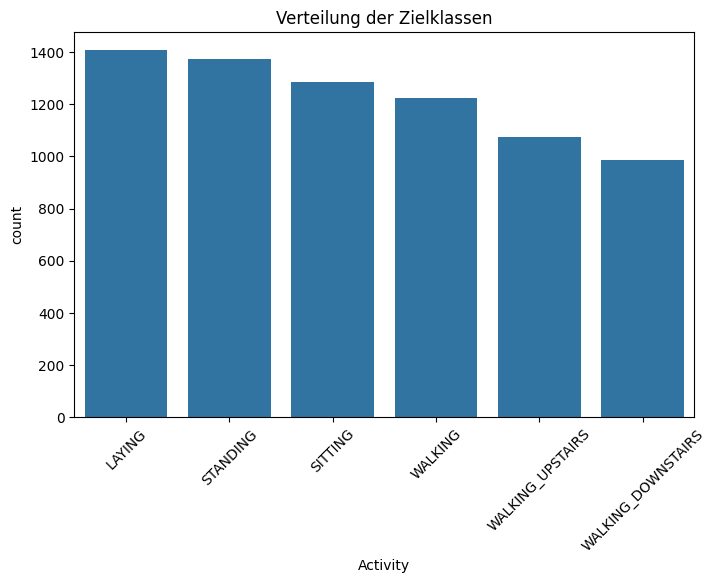

Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64
Activity
LAYING                19.137650
STANDING              18.688792
SITTING               17.491839
WALKING               16.675734
WALKING_UPSTAIRS      14.594668
WALKING_DOWNSTAIRS    13.411317
Name: proportion, dtype: float64


In [9]:
# Zielklassen-Verteilung
target_col = 'Activity'
plt.figure(figsize=(8, 5))
sns.countplot(x=target_col, data=train_df, order=train_df[target_col].value_counts().index)
plt.title("Verteilung der Zielklassen")
plt.xticks(rotation=45)
plt.show()

# Absolut- und Prozentverteilung
print(train_df[target_col].value_counts())
print(train_df[target_col].value_counts(normalize=True) * 100)

In [ ]:
# Korrelationsmatrix
corr = train_df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Korrelationsmatrix der numerischen Features")
plt.show()

In [ ]:
# Der Datensatz ist liegt bereits gereinigt vor, daher keine weiteren Schritte zur Datenbereinigung notwendig.
#Außerdem liegt ein train, test Split vor, daher keine weiteren Schritte zur Datenaufteilung notwendig.
# Fehlende Werte prüfen
print("Fehlende Werte im Trainingsset:\n", train_df.isnull().sum().sum())
print("Fehlende Werte im Testset:\n", test_df.isnull().sum().sum())

Fehlende Werte im Trainingsset:
 0
Fehlende Werte im Testset:
 0


## Data Preparation

Die folgende Funktion `prepare_data()` führt alle notwendigen Schritte zur Datenvorverarbeitung durch:

- Einlesen der CSV-Dateien
- Entfernen von Duplikaten
- Label-Encoding der Zielvariable
- Trennung von Features und Labels
- Skalierung der Merkmale mittels `StandardScaler`
- Umwandlung in das 3D-Format für LSTM-Modelle
- Konvertierung in PyTorch-Tensoren


In [ ]:
def prepare_data(train_csv, test_csv, target_col='Activity'):
    # CSV-Dateien laden
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    # Zielvariable label-encoden
    le = LabelEncoder()
    train_df[target_col] = le.fit_transform(train_df[target_col])
    test_df[target_col] = le.transform(test_df[target_col])

    # Features und Ziel trennen
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col].values
    X_val = test_df.drop(columns=[target_col])
    y_val = test_df[target_col].values

    # Feature-Skalierung
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Für LSTM: Umwandeln in 3D-Format (Batch, TimeSteps=1, Features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # In Torch-Tensoren umwandeln
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    return X_train, y_train, X_val, y_val, le


In [ ]:
# Aufruf prepare_data()
X_train, y_train, X_val, y_val, label_encoder = prepare_data("../data/train.csv", "../data/test.csv")

In [ ]:
# LSTM-Modell
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout=0.0, activation='relu'):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        else:
            raise ValueError("Unsupported activation function")

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM-Ausgabe: alle TimeSteps, alle Hidden States
        out = self.dropout(out[:, -1, :])  # Nur letzter TimeStep → Klassifikation
        out = self.activation(out)
        out = self.fc(out)
        return out


## Model Training
Die Funktion `train_model()` trainiert ein LSTM-Modell auf den vorbereiteten Daten. Dabei
- Definiert die LSTM-Architektur
- Initialisiert den Optimierer und die Verlustfunktion
- Führt das Training über mehrere Epochen durch
- Speichert das beste Modell basierend auf der Validierungsgenauigkeit  

In [ ]:
# Trainingsfunktion
def train_model(X_train, y_train, X_val, y_val,
                hidden_size=64,
                batch_size=64,
                lr=0.001,
                epochs=100,
                dropout=0.0,
                activation="relu",
                device='cpu',
                log_to_mlflow=None,
                num_layers=1,
                weight_decay=0.0):

    model = LSTMModel(
        input_size=X_train.shape[2],
        hidden_size=hidden_size,
        num_classes=len(torch.unique(torch.cat([y_train, y_val]))),
        num_layers=num_layers,
        dropout=dropout,
        activation=activation
    ).to(device)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    best_model_state = model.state_dict()
    best_labels, best_preds = [], []
    patience, counter = 20, 0
    final_val_loss = None

    for epoch in range(epochs):
        model.train()
        train_loss, all_train_preds, all_train_labels = 0, [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * yb.size(0)
            all_train_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_train_labels.extend(yb.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = np.mean(np.array(all_train_preds) == np.array(all_train_labels))
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)

        # Validierung
        model.eval()
        correct, total, val_loss = 0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += criterion(preds, yb).item() * yb.size(0)
                pred_labels = preds.argmax(dim=1)
                correct += (pred_labels == yb).sum().item()
                total += yb.size(0)
                all_preds.extend(pred_labels.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total if total > 0 else 0
        val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # MLflow logging
        if log_to_mlflow:
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "train_precision": train_precision,
                "train_recall": train_recall,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
            }, step=epoch)

        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_val_loss = val_loss
            best_model_state = model.state_dict()
            best_preds, best_labels = all_preds, all_labels
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"⏹ Early stopping at epoch {epoch+1}")
                break

    # Fallback falls keine besseren gefunden wurden
    if not best_preds or not best_labels:
        best_preds, best_labels = all_preds, all_labels
        final_val_loss = val_loss

    model.load_state_dict(best_model_state)
    final_precision = precision_score(best_labels, best_preds, average='weighted', zero_division=0)
    final_recall = recall_score(best_labels, best_preds, average='weighted', zero_division=0)
    final_f1 = f1_score(best_labels, best_preds, average='weighted', zero_division=0)

    return (
        train_acc, train_loss, train_precision, train_recall, train_f1,
        best_val_acc, final_val_loss, final_precision, final_recall, final_f1,
        model
    )


## Optuna Hyperparameter Tuning
Die Funktion `objective()` nutzt Optuna zur automatischen Optimierung der Hyperparameter des LSTM-Modells. Dabei werden folgende Schritte durchgeführt:
- Definition des Suchraums für Hyperparameter wie Lernrate, Anzahl der LSTM-Schichten und Neuronen pro Schicht
- Training des Modells mit den optimierten Hyperparametern
- Validierung der Modellleistung auf einem separaten Validierungsdatensatz  

In [ ]:
# Optuna Objective
def objective(trial, parent_run_id):
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    epochs = 10
    
    run_name = f"Trial{trial.number}_h{hidden_size}_b{batch_size}_lr{lr:.0e}"

    with mlflow.start_run(run_name=f"Trial_{trial.number}", nested=True, parent_run_id=parent_run_id) as run:
        mlflow.set_tag("trial_group", parent_run_id)
        mlflow.set_tag("is_parent", "false")

        train_acc, train_loss, train_prec, train_rec, train_f1, val_acc, val_loss, val_prec, val_rec, val_f1, model = train_model(
            X_train, y_train, X_val, y_val,
            hidden_size=hidden_size,
            batch_size=batch_size,
            lr=lr,
            epochs=epochs,
            dropout=dropout,
            activation=activation,
            num_layers=num_layers,
            weight_decay=weight_decay,
            device=device,
            log_to_mlflow=True
        )

        mlflow.log_params({
            "hidden_size": hidden_size,
            "batch_size": batch_size,
            "lr": lr,
            "dropout": dropout,
            "activation": activation,
            "num_layers": num_layers,
            "weight_decay": weight_decay
        })

        mlflow.log_metrics({
            "train_accuracy": train_acc,
            "train_loss": train_loss,
            "train_precision": train_prec,
            "train_recall": train_rec,
            "train_f1": train_f1,
            "val_accuracy": val_acc,
            "val_loss": val_loss,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1": val_f1
        })

        # Modell mit Signature loggen
        input_example = X_val[:1].cpu().numpy()
        model.eval()
        with torch.no_grad():
            output_example = model(torch.tensor(input_example).to(device)).cpu().numpy()

        signature = infer_signature(input_example, output_example)

        mlflow.pytorch.log_model(
            model,
            artifact_path="model",
            input_example=input_example,
            signature=signature
        )

        # User Attributes für spätere Auswertung
        trial.set_user_attr("val_accuracy", val_acc)
        trial.set_user_attr("val_loss", val_loss)
        trial.set_user_attr("val_precision", val_prec)
        trial.set_user_attr("val_recall", val_rec)
        trial.set_user_attr("val_f1", val_f1)
        trial.set_user_attr("mlflow_parent_run_id", parent_run_id)

        # Modell speichern (nur state_dict)
        model_dir = os.path.join("..", "model")
        os.makedirs(model_dir, exist_ok=True)
        model_path = os.path.join(model_dir, f"model_state_dict_trial_{trial.number}.pth")
        torch.save(model.state_dict(), model_path)
        mlflow.log_artifact(model_path)


    print(f"[Trial {trial.number}] val_acc={val_acc:.4f}, val_loss={val_loss:.4f}, precision={val_prec:.4f}, recall={val_rec:.4f}, f1={val_f1:.4f}")
    return val_acc



In [ ]:
# Optuna-Loop & MLflow-Tracking
# Optuna-Studie starten
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
parent_run_name = f"Optuna_Loop_{timestamp}"

with mlflow.start_run(run_name=parent_run_name, nested=False) as parent_run:
    mlflow.set_tags({
        "is_parent": "true",
        "experiment": "LSTM-HAR",
        "timestamp": timestamp
    })

    study = optuna.create_study(
        direction="maximize",
        study_name="lstm_har_study",
        storage="sqlite:///../optuna_lstm.db",
        load_if_exists=True
    )

    # Studie optimieren
    study.optimize(lambda trial: objective(trial, parent_run.info.run_id), n_trials=1, n_jobs=1)

    # Beste Ergebnisse loggen
    mlflow.log_metrics({
        "best_val_accuracy": study.best_trial.user_attrs.get("val_accuracy", 0),
        "best_val_loss": study.best_trial.user_attrs.get("val_loss", 0),
        "best_val_precision": study.best_trial.user_attrs.get("val_precision", 0),
        "best_val_recall": study.best_trial.user_attrs.get("val_recall", 0),
        "best_val_f1": study.best_trial.user_attrs.get("val_f1", 0)
    })

    # Trials extrahieren
    current_trials = [
        t for t in study.trials 
        if t.user_attrs.get("mlflow_parent_run_id") == parent_run.info.run_id
    ]

    if current_trials:
        records = []
        for trial in current_trials:
            trial_id = trial.number
            metrics = trial.user_attrs
            records.append({
                "trial": f"Trial {trial_id}",
                "accuracy": metrics.get("val_accuracy", 0),
                "loss": metrics.get("val_loss", 0),
                "precision": metrics.get("val_precision", 0),
                "recall": metrics.get("val_recall", 0),
                "f1": metrics.get("val_f1", 0)
            })

        df = pd.DataFrame(records)

        os.makedirs("../plots", exist_ok=True)

        # Einzelne Metriken als Balkendiagramm loggen
        metrics_name = ["accuracy", "loss", "precision", "recall", "f1"]
        for metric in metrics_name:
            fig = px.bar(df, x="trial", y=metric, title=f"Trials – {metric.capitalize()}", text_auto='.3s')
            fig.update_layout(xaxis_title="Trial", yaxis_title=metric.capitalize())
            file_name = f"../plots/metrics_{metric}.html"
            fig.write_html(file_name)
            mlflow.log_artifact(file_name)

        # Vergleich aller Metriken gemeinsam
        df_melted = df.melt(id_vars="trial", value_vars=metrics_name, var_name="metric", value_name="value")
        fig = px.bar(df_melted, x="trial", y="value", color="metric", barmode="group",
                     title="Vergleich aller Trials (val-Metriken)")
        fig.update_layout(xaxis_title="Trial", yaxis_title="Value")
        fig.write_html("../plots/metrics_comparison.html")
        mlflow.log_artifact("../plots/metrics_comparison.html")

        # CSV speichern
        df.to_csv("../plots/current_trials_metrics.csv", index=False)
        mlflow.log_artifact("../plots/current_trials_metrics.csv")
    else:
        print("Keine zugehörigen Trials für diesen Parent-Run gefunden.")

mlflow.end_run()

# Beste Parameter anzeigen
print("Beste Parameter:", study.best_params)
print("Beste Accuracy:", study.best_value)

[I 2025-06-28 15:30:06,963] Using an existing study with name 'lstm_har_study' instead of creating a new one.
2025/06/28 15:30:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-06-28 15:30:34,322] Trial 329 finished with value: 0.9480827960637936 and parameters: {'hidden_size': 128, 'batch_size': 32, 'lr': 0.0006883678538760291, 'dropout': 0.29493491433912933, 'activation': 'tanh', 'num_layers': 1, 'weight_decay': 0.0008647563899377345}. Best is trial 304 with value: 0.9640312181879878.


[Trial 329] val_acc=0.9481, val_loss=0.1441, precision=0.9488, recall=0.9481, f1=0.9482
Beste Parameter: {'hidden_size': 128, 'batch_size': 32, 'lr': 0.0006061898485484264, 'dropout': 0.29587384111382664, 'activation': 'tanh', 'num_layers': 2, 'weight_decay': 0.0003669704226611471}
Beste Accuracy: 0.9640312181879878


In [ ]:
# Optuna-Study laden
import optuna

study = optuna.load_study(
    study_name="lstm_har_study",
    storage="sqlite:///../optuna_lstm.db"
)

# Trial 328 extrahieren
trial_id = 328
trial = [t for t in study.trials if t.number == trial_id][0]
params = trial.params
print("Trial 328 Parameter:", params)

# Modell rekonstruieren mit extrahierten Parametern
model = LSTMModel(
    input_size=X_val.shape[2],
    hidden_size=int(params["hidden_size"]),
    num_layers=int(params["num_layers"]),
    dropout=float(params["dropout"]),
    activation=params["activation"],
    num_classes=len(np.unique(y_val.cpu().numpy()))
).to(device)

# state_dict laden
state_dict_path = f"../model/model_state_dict_trial_{trial_id}.pth"
model.load_state_dict(torch.load(state_dict_path, map_location=device))
model.eval()


Trial 328 Parameter: {'hidden_size': 128, 'batch_size': 32, 'lr': 0.00010151511445807279, 'dropout': 0.30550851638885507, 'activation': 'tanh', 'num_layers': 1, 'weight_decay': 0.0006405379553301095}


LSTMModel(
  (lstm): LSTM(562, 128, batch_first=True)
  (dropout): Dropout(p=0.30550851638885507, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (activation): Tanh()
)

## Anzeigen der generierten Plots

In [ ]:
from IPython.display import IFrame, display
import os

# Einzelmetriken
metrics = ["accuracy", "loss", "precision", "recall", "f1"]

# Alle Einzelmetriken anzeigen
for metric in metrics:
    file_path = f"../plots/metrics_{metric}.html"
    if os.path.exists(file_path):
        print(f"🔹 Metrik: {metric}")
        display(IFrame(src=file_path, width="100%", height=400))
    else:
        print(f"❌ Datei nicht gefunden: {file_path}")

# Gemeinsamer Vergleich aller Metriken
comparison_path = "../plots/metrics_comparison.html"
if os.path.exists(comparison_path):
    print("🔹 Vergleich aller Metriken:")
    display(IFrame(src=comparison_path, width="100%", height=500))
else:
    print("❌ Vergleichsplot nicht gefunden.")


🔹 Metrik: accuracy


🔹 Metrik: loss


🔹 Metrik: precision


🔹 Metrik: recall


🔹 Metrik: f1


🔹 Vergleich aller Metriken:


## Feature Importance
Die Permutation Feature Importance wird genutzt, um die Relevanz der einzelnen Merkmale für die Modellvorhersage zu bewerten. Diese Methode misst, wie stark sich die Modellleistung ändert, wenn die Werte eines Merkmals permutiert werden. Dadurch können wichtige Merkmale identifiziert werden, die für die Klassifikation entscheidend sind.

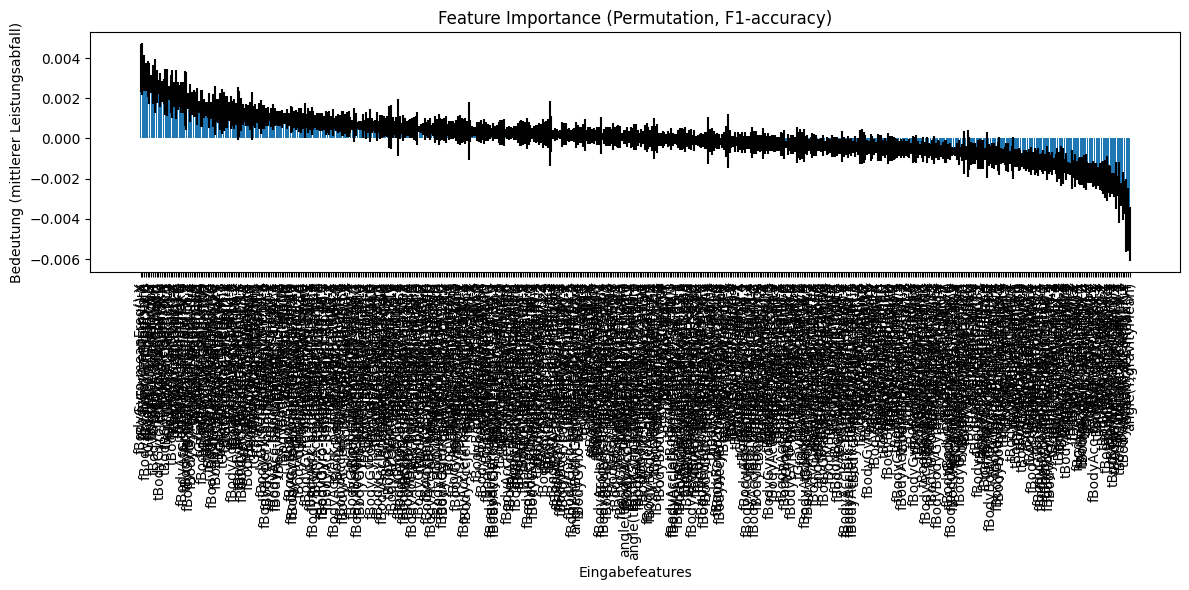

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Feature-Namen aus den Rohdaten (ohne Zielspalte)
feature_names = train_df.drop(columns=["Activity"]).columns.tolist()

# Wrapper für LSTM-Modell
class WrappedLSTM:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        # Dummy-Funktion – wird von permutation_importance nicht verwendet
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X.reshape(X.shape[0], 1, X.shape[1]), dtype=torch.float32).to(device)
        with torch.no_grad():
            preds = self.model(X_tensor).argmax(dim=1).cpu().numpy()
        return preds


# Daten vorbereiten für sklearn
X_val_2d = X_val.squeeze().cpu().numpy()
y_val_np = y_val.cpu().numpy()

# Modell wrappen
wrapped_model = WrappedLSTM(model)

# Permutation Importance berechnen
result = permutation_importance(
    wrapped_model,
    X_val_2d,
    y_val_np,
    n_repeats=10,
    random_state=42,
    scoring="accuracy"
)

# Ergebnisse sortieren
importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]

# Balkendiagramm anzeigen
plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Permutation, F1-accuracy)")
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.ylabel("Bedeutung (mittlerer Leistungsabfall)")
plt.xlabel("Eingabefeatures")
plt.tight_layout()
plt.show()


In [ ]:
# Ergebnisse sortieren
importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]

# Top 10 Indizes
top_10_indices = indices[:10]

# Feature-Namen und Werte extrahieren
top_10_features = [(feature_names[i], importances[i]) for i in top_10_indices]

# Ausgabe
for i, (feature, importance) in enumerate(top_10_features, 1):
    print(f"{i}. {feature}: {importance:.4f}")


1. fBodyGyro-meanFreq()-X: 0.0035
2. tBodyGyro-entropy()-X: 0.0035
3. fBodyAccMag-std(): 0.0033
4. fBodyAcc-bandsEnergy()-1,8: 0.0031
5. tBodyAcc-arCoeff()-X,4: 0.0030
6. tGravityAcc-arCoeff()-X,2: 0.0027
7. fBodyAccMag-energy(): 0.0027
8. tGravityAcc-energy()-Y: 0.0027
9. tBodyGyroJerk-arCoeff()-X,1: 0.0026
10. fBodyAccMag-mad(): 0.0026


In [ ]:
# Ergebnisse sortieren (bereits vorhanden)
importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)  # aufsteigend sortiert

# Bottom 10 Indizes
bottom_10_indices = indices[:10]

# Feature-Namen und Werte extrahieren
bottom_10_features = [(feature_names[i], importances[i]) for i in bottom_10_indices]

# Ausgabe
for i, (feature, importance) in enumerate(bottom_10_features, 1):
    print(f"{i}. {feature}: {importance:.4f}")


1. angle(Y,gravityMean): -0.0048
2. tGravityAcc-mean()-Y: -0.0040
3. tGravityAcc-max()-Y: -0.0038
4. tBodyAccJerk-arCoeff()-X,1: -0.0030
5. tBodyGyro-arCoeff()-Y,2: -0.0029
6. tBodyGyroJerk-arCoeff()-X,2: -0.0028
7. tGravityAcc-min()-Y: -0.0027
8. tBodyGyro-arCoeff()-Y,1: -0.0024
9. tBodyGyro-correlation()-X,Z: -0.0023
10. tBodyGyroJerkMag-arCoeff()4: -0.0023


## Vergleich mit Dummy Classifier
Die Ergebnisse des LSTM-Modells werden mit einem Dummy Classifier verglichen, um die Leistung des Modells zu bewerten. Der Dummy Classifier dient als Baseline, um zu überprüfen, ob das LSTM-Modell signifikant besser abschneidet als ein zufälliges Modell.

In [ ]:
strategies = ["most_frequent", "stratified", "uniform"]

for strat in strategies:
    dummy = DummyClassifier(strategy=strat, random_state=42)
    dummy.fit(X_val_2d, y_val_np)
    y_pred = dummy.predict(X_val_2d)
    print(f"\n📊 Dummy Classifier ({strat}):")
    print(classification_report(y_val_np, y_pred, digits=4))


NameError: name 'prepare_data' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics_named(y_true, y_pred, name):
    return {
        "Modell": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1": f1_score(y_true, y_pred, average='weighted')
    }

# Liste für Ergebnisse
results = []

# 🔹 Dummy Classifier (verschiedene Strategien)
strategies = ["most_frequent", "stratified", "uniform"]
for strat in strategies:
    dummy = DummyClassifier(strategy=strat, random_state=42)
    dummy.fit(X_val_2d, y_val_np)
    y_pred = dummy.predict(X_val_2d)
    results.append(compute_metrics_named(y_val_np, y_pred, f"Dummy ({strat})"))

# 🔹 Logistic Regression (als weitere Baseline)
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_val_2d, y_val_np)
y_pred_logreg = logreg.predict(X_val_2d)
results.append(compute_metrics_named(y_val_np, y_pred_logreg, "Logistic Regression"))

# 🔹 LSTM Modell (dein trainiertes)
y_pred_lstm = model(X_val).argmax(dim=1).cpu().numpy()
results.append(compute_metrics_named(y_val_np, y_pred_lstm, "LSTM"))

# 📊 DataFrame erzeugen
df_model_comparison = pd.DataFrame(results).set_index("Modell").round(4)

plt.figure(figsize=(10, 6))
sns.heatmap(df_model_comparison, annot=True, fmt=".4f", cmap="Blues")
plt.title("🔍 Vergleich der Modelle")
plt.show()


## Skript um den MLflow Tracking Server zu starten

```bash
# MLflow UI starten
import subprocess

# === Konfiguration ===
mlruns_dir = "../logs/mlruns"
mlflow_port = 5000

# === Schritt 1: Sicherstellen, dass logs/mlruns existiert ===
os.makedirs(mlruns_dir, exist_ok=True)

# === Schritt 2: MLflow UI starten ===
print(f"[INFO] Starte MLflow UI auf Port {mlflow_port} ...")
print(f"[INFO] Backend-Store-URI: file:{mlruns_dir}")

try:
    subprocess.run([
        "mlflow", "ui",
        "--backend-store-uri", f"file:{mlruns_dir}",
        "--port", str(mlflow_port)
    ])
except FileNotFoundError:
    print("[ERROR] MLflow ist nicht installiert oder nicht im PATH.")

```


Evaluation bzw die Grafiken wurden automatisiert und sind über MlFlow pro Trial anzeigbar. Diese Plots zeigen die Metriken wie Accuracy, Loss, Precision, Recall und F1-Score für die verschiedenen Trials an.